# Visualizing survey footprints 

The goal of this notebook is to provide more informative visualizations of the Galactic Plane Survey footprints.

In [1]:
from os import path
from astropy import units as u 
from mw_plot import MWSkyMap
import skyproj
import json
import config_utils
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord 
from astropy import units as u
%matplotlib inline

# Configure path to local repository
root_dir = '/Users/rstreet/software/rgps'

Firstly, we will load the information on the various survey designs proposed by the community.  

In [12]:
config = config_utils.read_config(path.join(root_dir, 'config', 'rgps_survey_regions.json'))

The goal is to superimpose these footprints over a background map of the Milky Way.  There are a number of options available.  The Aladin viewer tool is probably the most sophisticated, but is Javascript based since its intended for web-based displays.  LIGO has also developed a sophisticated plotting package but while this handles regions very well, it doesn't provide the overlay of the sky image that would be helpful for our purposes.  The packages that seem to best handle what we need are explored here. 

## MW_plot
The mw_plot package is designed to overlay points on top of a background image of the sky. The following example is based on the [package's documentation](https://milkyway-plot.readthedocs.io). 

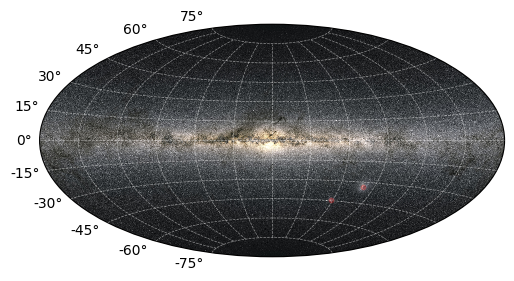

In [3]:
# Highlight the positions of the Magellanic Clouds
mw1 = MWSkyMap(projection='aitoff', grayscale=False, grid='galactic')
mw1.scatter([78.77, 16.26]*u.deg, [-69.01, -72.42]*u.deg, c="r", s=10, alpha=0.2)

The really nice feature about this package is that it offers a number of all-sky background plots in different wavelengths.  The limitation of this package seems to be that it will superimpose only a set of points and doesn't handle polygons. 

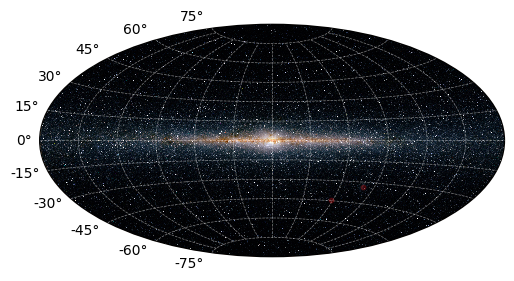

In [4]:
# Let's see the Milky Way in NIR
mw1 = MWSkyMap(projection='aitoff', grayscale=False, grid='galactic', background='infrared')
mw1.scatter([78.77, 16.26]*u.deg, [-69.01, -72.42]*u.deg, c="r", s=10, alpha=0.2)

## SkyProJ 

[SkyProJ](https://skyproj.readthedocs.io/) offers more sophistcated tools for plotting sky regions, and also handles HEALpixel maps.  Like mw_plot it is designed to integrate with matplotlib. 

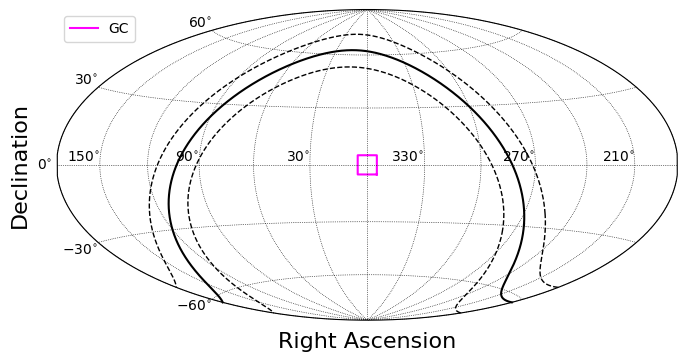

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
sp = skyproj.HammerSkyproj(ax=ax)
sp.draw_polygon([-5.0, 5.0, 5.0, -5.0, -5.0], [-5.0, -5.0, 5.0, 5.0, -5.0], edgecolor='magenta', label='GC')
sp.draw_milky_way()
sp.legend()
plt.show()

Unfortunately, it doesn't seem to offer the background image functions, and experimenting with them both gives no obvious way to combine their functionality without resetting the axes. 

## Plotting survey regions

My goal here is to visually compare the requested survey regions with a background image of the NIR Milky Way, so let's continue with mw_plot for the time being, and plot the GRIPS region by way of example. 

In [6]:
# Definition of the GRIPS survey region from Paladini et al
config['Paladini']

{'F213': [{'l': [10.0, 60.0], 'b': [-2.5, 2.5]},
  {'l': [-60.0, -10.0], 'b': [-2.5, 2.5]},
  {'l': [-10, 80.0], 'b': [-8.0, 8.0]},
  {'l': [-10.0, 30.0], 'b': [-8.0, 8.0]}],
 'comment': 'Galactic Plane Science',
 'ready_for_use': True}

In [13]:
def get_region_tiles(region_list):
    """
    Function to return a set of scatter points representing a region.  
    Regions can be defined as a list of boxes in the form: {'l': [l_min, l_max], 'b': [b_min, b_max]}
    all units in degrees
    Function returns a corresponding list of the scatter points for each region
    """
    points = []
    
    for i,region in enumerate(region_list):
        
        # Convert the region into a meshgrid of points.  These need to be in RA,Dec
        nl = int(region['l'][1] - region['l'][0])
        nb = int(region['b'][1] - region['b'][0])
        l = np.linspace(region['l'][0], region['l'][1], nl)
        b = np.linspace(region['b'][0], region['b'][1], nb)
        x_1, y_1 = np.meshgrid(l, b)

        # Convert to RA, Dec coordinates
        s = SkyCoord(l=x_1, b=y_1, frame='galactic', unit=(u.deg, u.deg))
        s = s.transform_to('icrs')
        points.append(s)
        
    return points

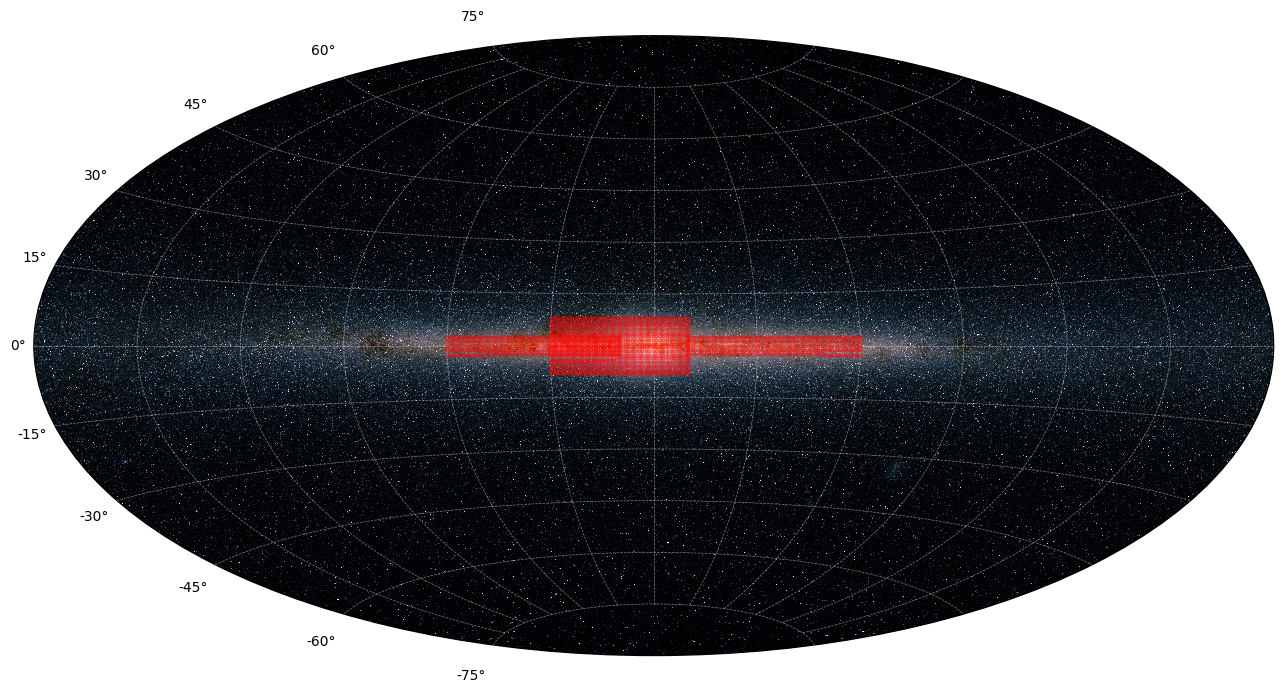

In [14]:
# Plot the Milky Way in NIR
mw1 = MWSkyMap(projection='aitoff', grayscale=False, grid='galactic', background='infrared', figsize=(16,10))

# Overlay the GRIPS region
points = get_region_tiles(config['Paladini']['F213'])
for s in points:
    mw1.scatter(s.ra.deg*u.deg, s.dec.deg*u.deg, c="r", s=5, alpha=0.4)